**Course website**: https://github.com/leomiquelutti/UFU-geofisica-1

**Note**: This notebook is part of the course "Geofísica 1" of Geology program of the 
[Universidade Federal de Uberlândia](http://www.ufu.br/). 
All content can be freely used and adapted under the terms of the 
[Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)

Agradecimentos especiais ao [Leonardo Uieda](www.leouieda.com)

Esse documento que você está usando é um [Jupyter notebook](http://jupyter.org/). É um documento interativo que mistura texto (como esse), código (como abaixo), e o resultado de executar o código (números, texto, figuras, videos, etc).

# Magnetometria - modelando a anomalia magnética de campo total gerada por prismas e esferas

## Objetivos

* Visualizar a anomalia magnética gerada por esferas.
* Verificar como os valores da anomalia variam com a dimensão do corpo.
* Verificar como os valores da anomalia variam com a profundidade do corpo.
* Verificar como os valores da anomalia variam com a magnetização do corpo, lembrando que esta é uma grandeza vetorial.

## Instruções

O notebook te fornecerá exemplos interativos que trabalham os temas abordados no questionário. Utilize esses exemplos para responder as perguntas.

As células com números ao lado, como `In [1]:`, são código [Python](http://python.org/). Algumas dessas células não produzem resultado e servem de preparação para os exemplos interativos. Outras, produzem gráficos interativos. **Você deve executar todas as células, uma de cada vez**, mesmo as que não produzem gráficos.

Para executar uma célula, clique em cima dela e aperte `Shift + Enter`. O foco (contorno verde ou cinza em torno da célula) deverá passar para a célula abaixo. Para rodá-la, aperte `Shift + Enter` novamente e assim por diante. Você pode executar células de texto que não acontecerá nada.

In [1]:
from fatiando import mesher, gridder, utils
from fatiando.gravmag import sphere, prism, transform
from fatiando.mesher import Polygon
from fatiando.vis import mpl
import numpy as np

C:\Users\leomi\Anaconda2\lib\site-packages\fatiando\vis\mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [2]:
def prism2polygon(prism):
    vertices = [[prism.x1, prism.y1],
               [prism.x2, prism.y1],
               [prism.x2, prism.y2],
               [prism.x1, prism.y2]]
    return vertices

def sphere2polygon(sphere):
    vertices = np.empty([360,2])
    for i in range(360):
        coord = [sphere.x + sphere.radius*np.cos(np.pi*i/180), sphere.y + sphere.radius*np.sin(np.pi*i/180)]
        vertices[i] = coord
    return vertices

### Inclinação e declinação
A célula abaixo contém valores de inclinação e declinação definidos pelo usuário. **Altere-os e execute novamente o programa para observar como o resultado se comporta**.

In [3]:
# Set the inclination and declination of the regional field
inc = -30
dec = 15

### Modelo
A célula abaixo contém o modelo de **esferas** definidos pelo usuário. 

In [4]:
# Create a sphere model with induced magnetization
modelSphere = [
    mesher.Sphere(-2000, -2000, 600, 500,
                  {'magnetization': utils.ang2vec(10, inc, dec)}),
    mesher.Sphere(4000, 4000, 100, 100,
                  {'magnetization': utils.ang2vec(10, inc, dec)})]

A célula abaixo contém o modelo de **prismas** definidos pelo usuário.

**CUIDADO PARA NÃO SOBREPOR AS ESFERAS E PRISMAS**

In [5]:
# Create a two-prism model with induced magnetization
modelPrism = [
    mesher.Prism(2800, 3200, -2000, 2000, 100, 1100,
                  {'magnetization': utils.ang2vec(10, inc, dec)}),
    mesher.Prism(-4000, 0, 4200, 3800, 100, 1100,
                  {'magnetization': utils.ang2vec(10, inc, dec)})]

**Altere-os e execute novamente o programa para observar como o resultado se comporta**. 

Tente adicionar esferas com parâmetros diferentes, lembrando que 

`mesher.Sphere(x, y, z, r, {'magnetization': utils.ang2vec(intensity, inclination, declination)})`

`mesher.Prism(x1, x2, y1, y2, z1, z2, {'magnetization': utils.ang2vec(intensity, inclination, declination)})`

Documentação para `mesher.sphere` se encontra [aqui](https://www.fatiando.org/api/mesher.html#fatiando.mesher.Sphere) e para `mesher.prism` [aqui](https://www.fatiando.org/api/mesher.html#fatiando.mesher.Prism). 

__Lembre-se__ que para "desligar" um corpo do modelo, basta associar o valor `0` no campo `intensity`

A célula abaixo define um grid e calcula a anomalia de acordo com os parâmetros do usuário.

In [6]:
# Create a regular grid at 100m height
shape = (100, 100)
area = (-5000, 5000, -5000, 5000)
xp, yp, zp = gridder.regular(area, shape, z=-100)
# Calculate the anomaly for a given regional field
#tf = sphere.tf(xp, yp, zp, modelSphere, inc, dec) + prism.tf(xp, yp, zp, modelPrism, inc, dec)
#utils.contaminate(prism.gz(x, y, z, model), 0.5, seed=0)
tf = utils.contaminate(sphere.tf(xp, yp, zp, modelSphere, inc, dec) + prism.tf(xp, yp, zp, modelPrism, inc, dec), 
                       0.005, seed=0, percent=True)

A célula abaixo apenas transforma os prismas e esferas em projeções poligonais para visualização em mapa.

In [7]:
pol = np.empty(modelPrism.__len__() + modelSphere.__len__(), dtype=object)
for i in range(modelPrism.__len__()):
    pol[i] = Polygon(prism2polygon(modelPrism[i]))
for i in range(modelSphere.__len__()):
    pol[i + modelPrism.__len__()] = Polygon(sphere2polygon(modelSphere[i]))

A célula abaixo cria a imagem da _anomalia de campo total_.

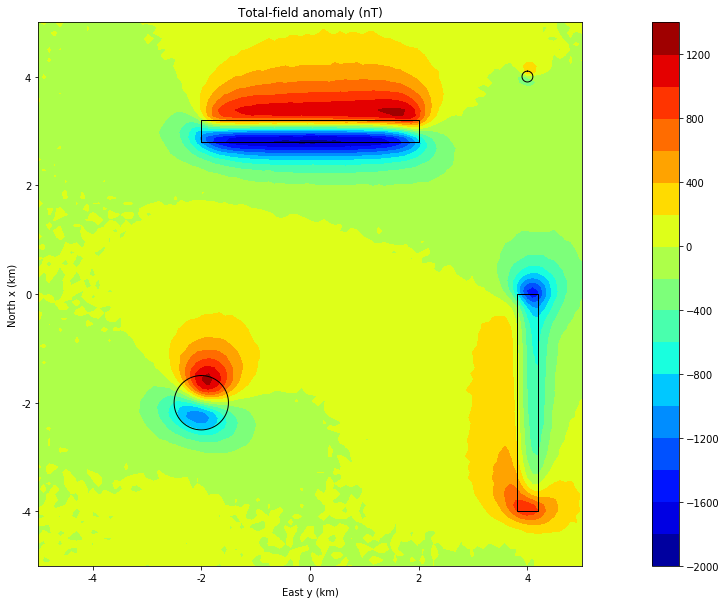

In [8]:
# Plot
mpl.figure(figsize=(25, 10))
mpl.title("Total-field anomaly (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, tf, shape, 15)
mpl.colorbar()
for i in range(pol.__len__()):
    mpl.polygon(pol[i], '-k', xy2ne=True)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.m2km()
mpl.show()

As células abaixo calculam as __derivadas__ do campo nas direções __x__, __y__ e __z__ e então plotam

In [9]:
tfx = transform.derivx(xp, yp, tf, shape)
tfy = transform.derivy(xp, yp, tf, shape)
tfz = transform.derivz(xp, yp, tf, shape)

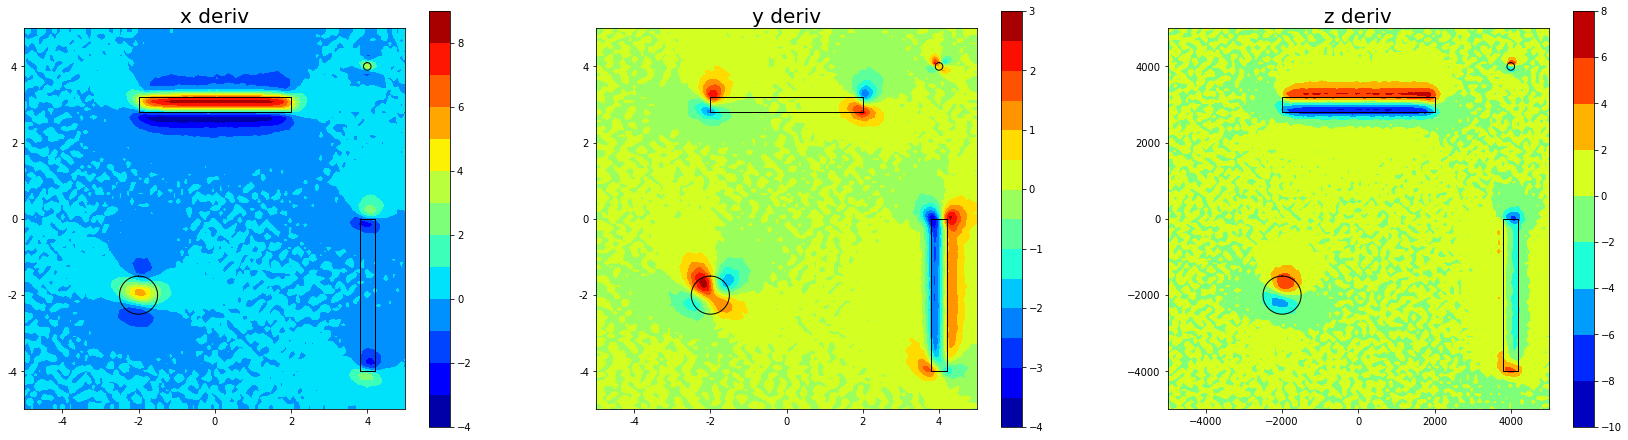

In [10]:
# Plot
mpl.figure(figsize=(25, 10))
mpl.subplots_adjust(top=0.95, left=0.05, right=0.95)
mpl.subplot(1, 3, 1)
mpl.title("x deriv", fontsize=20)
mpl.axis('scaled')
levels = mpl.contourf(yp, xp, tfx, shape, 12)
mpl.colorbar(shrink=0.7)
for i in range(pol.__len__()):
    mpl.polygon(pol[i], '-k', xy2ne=True)
#mpl.contour(yp, xp, gxz, shape, 12, color='k')
mpl.m2km()
mpl.subplot(1, 3, 2)
mpl.title("y deriv", fontsize=20)
mpl.axis('scaled')
levels = mpl.contourf(yp, xp, tfy, shape, 12)
mpl.colorbar(shrink=0.7)
#mpl.contour(yp, xp, gyz, shape, 12, color='k')
for i in range(pol.__len__()):
    mpl.polygon(pol[i], '-k', xy2ne=True)
mpl.m2km()
mpl.subplot(1, 3, 3)
mpl.title("z deriv", fontsize=20)
mpl.axis('scaled')
levels = mpl.contourf(yp, xp, tfz, shape, 8)
mpl.colorbar(shrink=0.7)
for i in range(pol.__len__()):
    mpl.polygon(pol[i], '-k', xy2ne=True)
#mpl.contour(yp, xp, gzz, shape, levels, color='k')
mpl.show()

As células abaixo calculam a __continuação para cima__ do campo e então plotam

In [11]:
height = 1000  # How much higher to go
tfcontf = transform.upcontinue(xp, yp, tf, shape, height)
tf_true = sphere.tf(xp, yp, zp - height, modelSphere, inc, dec) + prism.tf(xp, yp, zp - height, modelPrism, inc, dec)

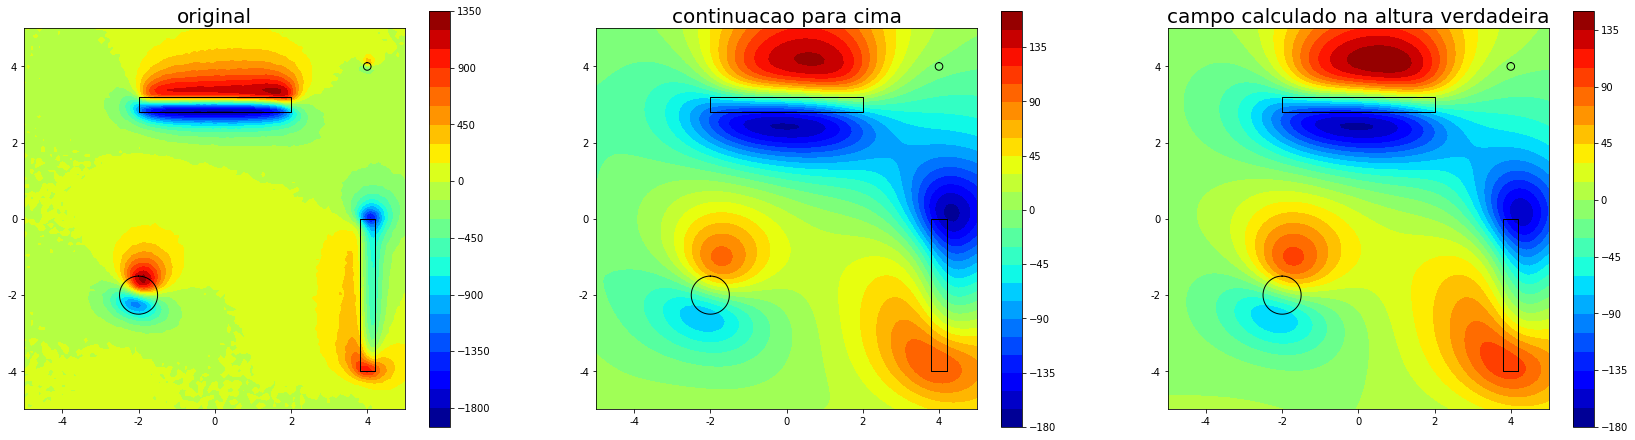

In [12]:
# Plot
mpl.figure(figsize=(25, 10))
mpl.subplots_adjust(top=0.95, left=0.05, right=0.95)
mpl.subplot(1, 3, 1)
mpl.title("original", fontsize=20)
mpl.axis('scaled')
levels = mpl.contourf(yp, xp, tf, shape, 30)
mpl.colorbar(shrink=0.7)
for i in range(pol.__len__()):
    mpl.polygon(pol[i], '-k', xy2ne=True)
#mpl.contour(yp, xp, gxz, shape, 12, color='k')
mpl.m2km()
mpl.subplot(1, 3, 2)
mpl.title("continuacao para cima", fontsize=20)
mpl.axis('scaled')
levels = mpl.contourf(yp, xp, tfcontf, shape, 30)
mpl.colorbar(shrink=0.7)
for i in range(pol.__len__()):
    mpl.polygon(pol[i], '-k', xy2ne=True)
#mpl.contour(yp, xp, gyz, shape, 12, color='k')
mpl.m2km()
mpl.subplot(1, 3, 3)
mpl.title("campo calculado na altura verdadeira", fontsize=20)
mpl.axis('scaled')
levels = mpl.contourf(yp, xp, tf_true, shape, 30)
mpl.colorbar(shrink=0.7)
for i in range(pol.__len__()):
    mpl.polygon(pol[i], '-k', xy2ne=True)
#mpl.contour(yp, xp, gyz, shape, 12, color='k')
mpl.m2km()

As células abaixo calculam a __redução ao pólo__ do campo e então plotam

In [13]:
pole = transform.reduce_to_pole(xp, yp, tf, shape, inc, dec, sinc=inc, sdec=dec)
# Calculate the true value at the pole for comparison
truetf = sphere.tf(xp, yp, zp, modelSphere, 90, 0, pmag=utils.ang2vec(10, 90, 0)) + prism.tf(xp, yp, zp, modelPrism, 90, 0, pmag=utils.ang2vec(10, 90, 0))
#truetf = sphere.tf(xp, yp, zp, modelSphere, 90, 0) + prism.tf(xp, yp, zp, modelPrism, 90, 0)

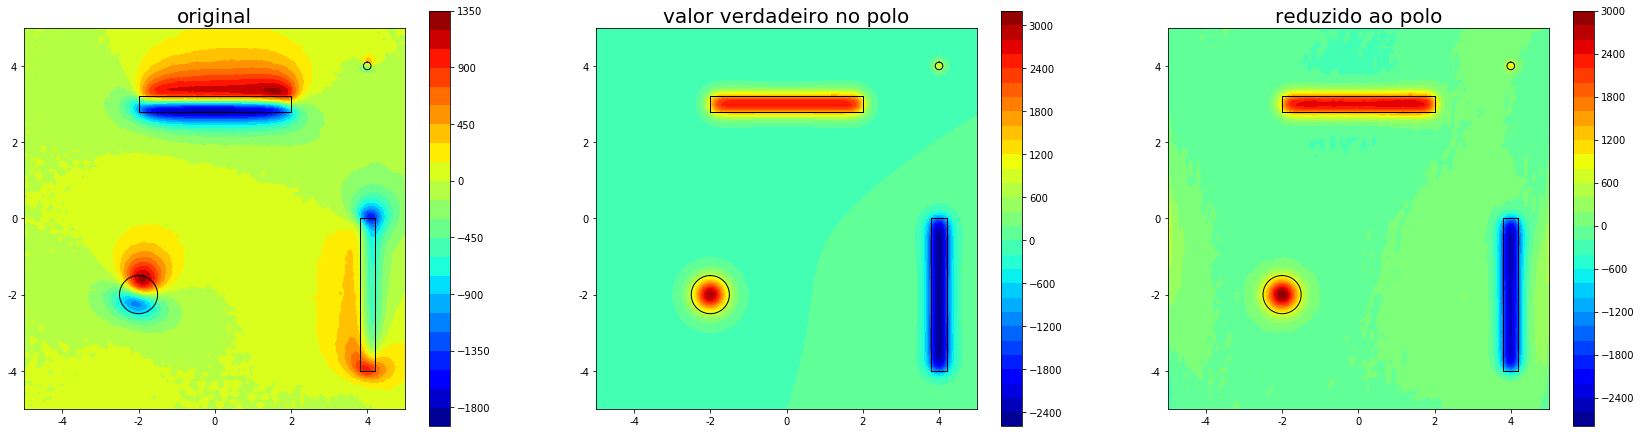

In [14]:
# Plot
mpl.figure(figsize=(25, 10))
mpl.subplots_adjust(top=0.95, left=0.05, right=0.95)
mpl.subplot(1, 3, 1)
mpl.title("original", fontsize=20)
mpl.axis('scaled')
levels = mpl.contourf(yp, xp, tf, shape, 30)
mpl.colorbar(shrink=0.7)
for i in range(pol.__len__()):
    mpl.polygon(pol[i], '-k', xy2ne=True)
#mpl.contour(yp, xp, gxz, shape, 12, color='k')
mpl.m2km()
mpl.subplot(1, 3, 2)
mpl.title("valor verdadeiro no polo", fontsize=20)
mpl.axis('scaled')
levels = mpl.contourf(yp, xp, truetf, shape, 30)
mpl.colorbar(shrink=0.7)
for i in range(pol.__len__()):
    mpl.polygon(pol[i], '-k', xy2ne=True)
#mpl.contour(yp, xp, gyz, shape, 12, color='k')
mpl.m2km()
mpl.subplot(1, 3, 3)
mpl.title("reduzido ao polo", fontsize=20)
mpl.axis('scaled')
levels = mpl.contourf(yp, xp, pole, shape, 30)
mpl.colorbar(shrink=0.7)
for i in range(pol.__len__()):
    mpl.polygon(pol[i], '-k', xy2ne=True)
#mpl.contour(yp, xp, gyz, shape, 12, color='k')
mpl.m2km()

As células abaixo calculam a __amplitude do gradiente total__ (também chamado de __sinal analítico__) do campo e então plotam

In [15]:
total_grad_amp = transform.tga(xp, yp, tf, shape)

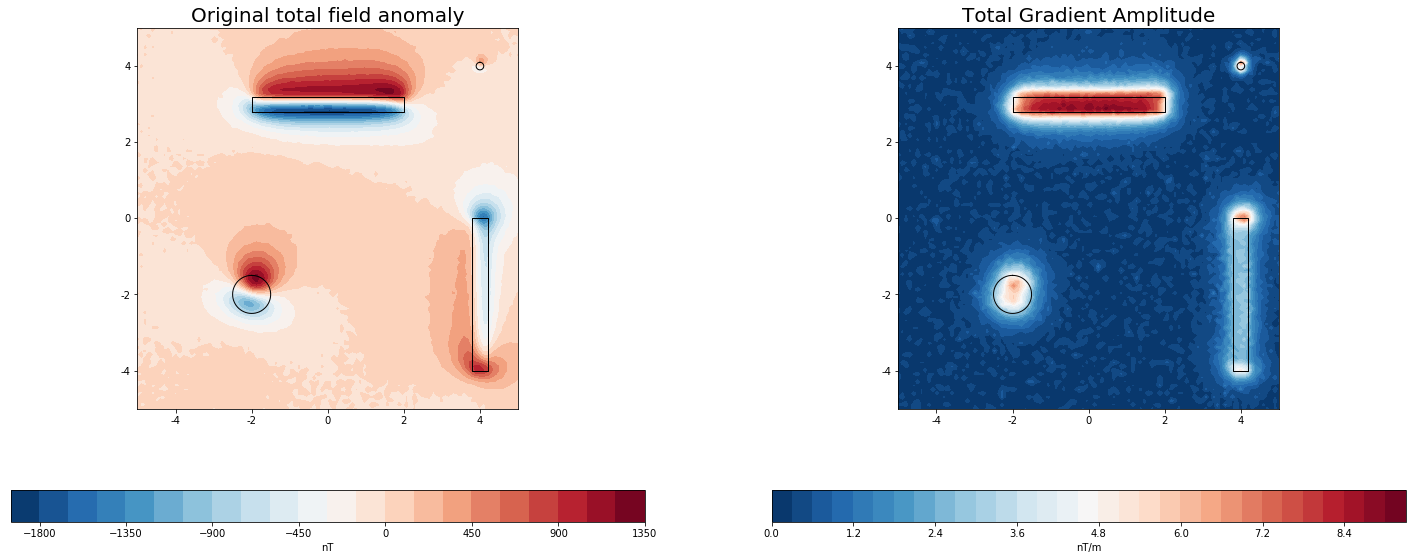

In [16]:
#Plot
mpl.figure(figsize=(25, 10))
mpl.subplot(1, 2, 1)
mpl.title("Original total field anomaly", fontsize=20)
mpl.axis('scaled')
mpl.contourf(yp, xp, tf, shape, 30, cmap=mpl.cm.RdBu_r)
mpl.colorbar(orientation='horizontal').set_label('nT')
for i in range(pol.__len__()):
    mpl.polygon(pol[i], '-k', xy2ne=True)
mpl.m2km()
mpl.subplot(1, 2, 2)
mpl.title("Total Gradient Amplitude", fontsize=20)
mpl.axis('scaled')
mpl.contourf(yp, xp, total_grad_amp, shape, 30, cmap=mpl.cm.RdBu_r)
mpl.colorbar(orientation='horizontal').set_label('nT/m')
for i in range(pol.__len__()):
    mpl.polygon(pol[i], '-k', xy2ne=True)
mpl.m2km()
mpl.show()

## Parte 2 - modelo prismas e esferas com magnetização **induzida** e **remanente**.

In [17]:
# Create a sphere model
modelSphere = [
    # two with induced magnetization
#    mesher.Sphere(0, 0, 600, 500,
#                  {'magnetization': utils.ang2vec(0, inc, dec)}),
    mesher.Sphere(-3000, -3000, 600, 500,
                  {'magnetization': utils.ang2vec(10, inc, dec)}),
    # and one with remanent
    mesher.Sphere(0, 0, 600, 500,
                  {'magnetization': utils.ang2vec(7, 0, -50)})]

In [18]:
# Create a prism model
modelPrism = [
    # two with induced magnetization
    mesher.Prism(2800, 3200, -2000, 2000, 100, 1100,
                  {'magnetization': utils.ang2vec(10, inc, dec)}),
#    mesher.Prism(-4000, 0, 4200, 3800, 100, 1100,
#                  {'magnetization': utils.ang2vec(10, inc, dec)}),
    # and one with remanent
    mesher.Prism(-4000, 0, 4200, 3800, 100, 1100,
                  {'magnetization': utils.ang2vec(7, 0, -20)})]

In [19]:
# Create a regular grid at 100m height
shape = (100, 100)
area = (-5000, 5000, -5000, 5000)
xp, yp, zp = gridder.regular(area, shape, z=-100)
# Calculate the anomaly for a given regional field
#tf = sphere.tf(xp, yp, zp, modelSphere, inc, dec) + prism.tf(xp, yp, zp, modelPrism, inc, dec)
#utils.contaminate(prism.gz(x, y, z, model), 0.5, seed=0)
tf = utils.contaminate(sphere.tf(xp, yp, zp, modelSphere, inc, dec) + prism.tf(xp, yp, zp, modelPrism, inc, dec), 
                       0.005, seed=0, percent=True)

A célula abaixo apenas transforma os prismas e esferas em projeções poligonais para visualização em mapa.

In [20]:
pol = np.empty(modelPrism.__len__() + modelSphere.__len__(), dtype=object)
for i in range(modelPrism.__len__()):
    pol[i] = Polygon(prism2polygon(modelPrism[i]))
for i in range(modelSphere.__len__()):
    pol[i + modelPrism.__len__()] = Polygon(sphere2polygon(modelSphere[i]))

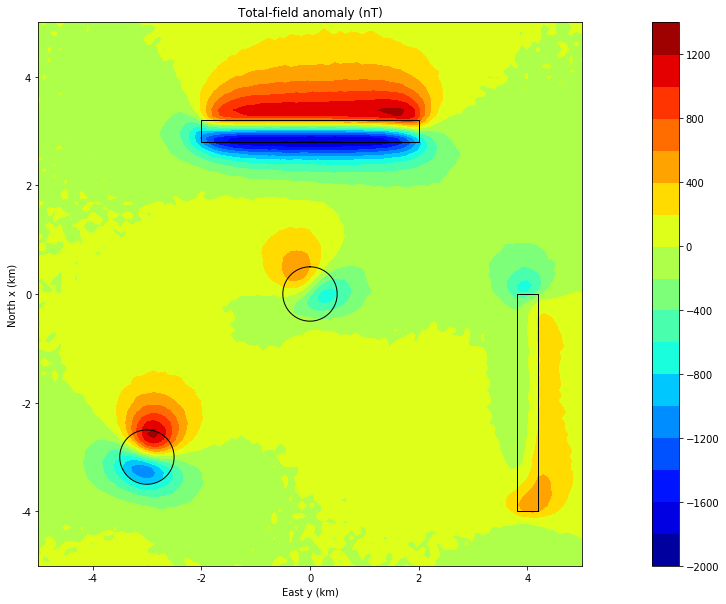

In [21]:
# Plot
mpl.figure(figsize=(25, 10))
mpl.title("Total-field anomaly (nT)")
mpl.axis('scaled')
mpl.contourf(yp, xp, tf, shape, 15)
mpl.colorbar()
for i in range(pol.__len__()):
    mpl.polygon(pol[i], '-k', xy2ne=True)
mpl.xlabel('East y (km)')
mpl.ylabel('North x (km)')
mpl.m2km()
mpl.show()

As células abaixo calculam as __derivadas__ do campo nas direções __x__, __y__ e __z__ e então plotam

In [22]:
tfx = transform.derivx(xp, yp, tf, shape)
tfy = transform.derivy(xp, yp, tf, shape)
tfz = transform.derivz(xp, yp, tf, shape)

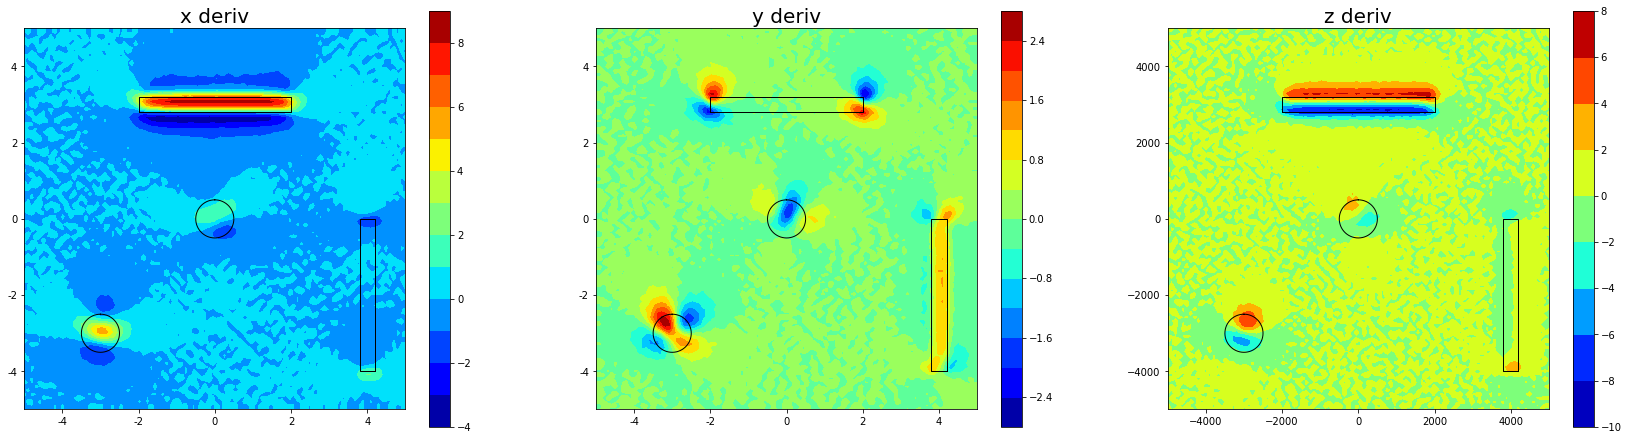

In [23]:
# Plot
mpl.figure(figsize=(25, 10))
mpl.subplots_adjust(top=0.95, left=0.05, right=0.95)
mpl.subplot(1, 3, 1)
mpl.title("x deriv", fontsize=20)
mpl.axis('scaled')
levels = mpl.contourf(yp, xp, tfx, shape, 12)
mpl.colorbar(shrink=0.7)
for i in range(pol.__len__()):
    mpl.polygon(pol[i], '-k', xy2ne=True)
#mpl.contour(yp, xp, gxz, shape, 12, color='k')
mpl.m2km()
mpl.subplot(1, 3, 2)
mpl.title("y deriv", fontsize=20)
mpl.axis('scaled')
levels = mpl.contourf(yp, xp, tfy, shape, 12)
mpl.colorbar(shrink=0.7)
#mpl.contour(yp, xp, gyz, shape, 12, color='k')
for i in range(pol.__len__()):
    mpl.polygon(pol[i], '-k', xy2ne=True)
mpl.m2km()
mpl.subplot(1, 3, 3)
mpl.title("z deriv", fontsize=20)
mpl.axis('scaled')
levels = mpl.contourf(yp, xp, tfz, shape, 8)
mpl.colorbar(shrink=0.7)
for i in range(pol.__len__()):
    mpl.polygon(pol[i], '-k', xy2ne=True)
#mpl.contour(yp, xp, gzz, shape, levels, color='k')
mpl.show()

As células abaixo calculam a __continuação para cima__ do campo e então plotam

In [24]:
height = 1000  # How much higher to go
tfcontf = transform.upcontinue(xp, yp, tf, shape, height)
tf_true = sphere.tf(xp, yp, zp - height, modelSphere, inc, dec) + prism.tf(xp, yp, zp - height, modelPrism, inc, dec)

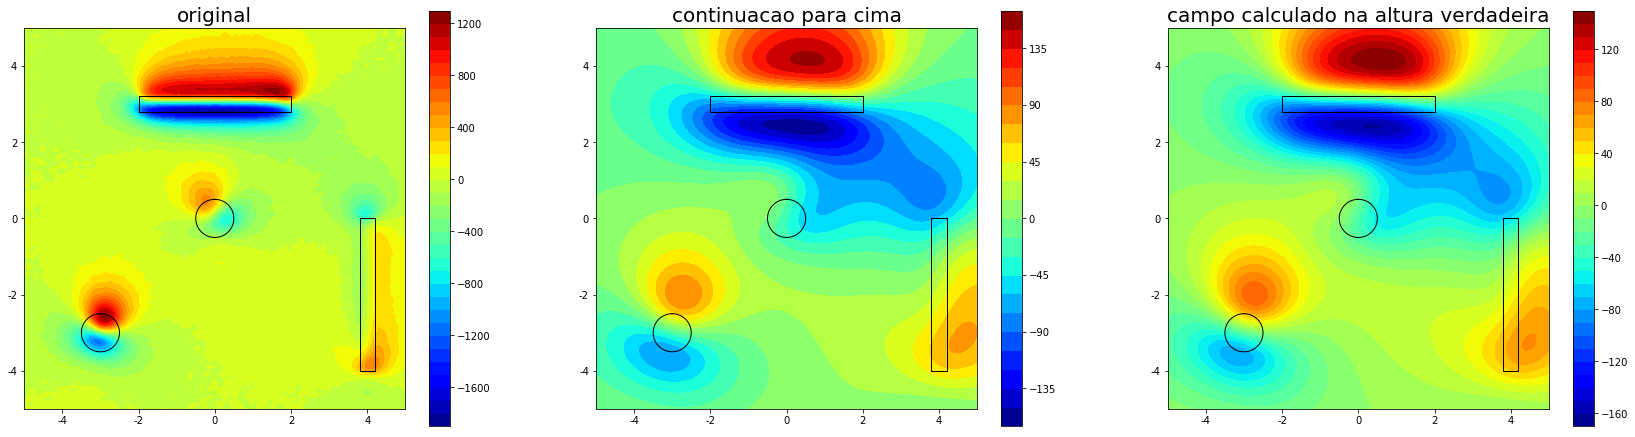

In [25]:
# Plot
mpl.figure(figsize=(25, 10))
mpl.subplots_adjust(top=0.95, left=0.05, right=0.95)
mpl.subplot(1, 3, 1)
mpl.title("original", fontsize=20)
mpl.axis('scaled')
levels = mpl.contourf(yp, xp, tf, shape, 30)
mpl.colorbar(shrink=0.7)
for i in range(pol.__len__()):
    mpl.polygon(pol[i], '-k', xy2ne=True)
#mpl.contour(yp, xp, gxz, shape, 12, color='k')
mpl.m2km()
mpl.subplot(1, 3, 2)
mpl.title("continuacao para cima", fontsize=20)
mpl.axis('scaled')
levels = mpl.contourf(yp, xp, tfcontf, shape, 30)
mpl.colorbar(shrink=0.7)
for i in range(pol.__len__()):
    mpl.polygon(pol[i], '-k', xy2ne=True)
#mpl.contour(yp, xp, gyz, shape, 12, color='k')
mpl.m2km()
mpl.subplot(1, 3, 3)
mpl.title("campo calculado na altura verdadeira", fontsize=20)
mpl.axis('scaled')
levels = mpl.contourf(yp, xp, tf_true, shape, 30)
mpl.colorbar(shrink=0.7)
for i in range(pol.__len__()):
    mpl.polygon(pol[i], '-k', xy2ne=True)
#mpl.contour(yp, xp, gyz, shape, 12, color='k')
mpl.m2km()

As células abaixo calculam a __redução ao pólo__ do campo e então plotam

In [26]:
pole = transform.reduce_to_pole(xp, yp, tf, shape, inc, dec, sinc=inc, sdec=dec)
# Calculate the true value at the pole for comparison
truetf = sphere.tf(xp, yp, zp, modelSphere, 90, 0, pmag=utils.ang2vec(10, 90, 0)) + prism.tf(xp, yp, zp, modelPrism, 90, 0, pmag=utils.ang2vec(10, 90, 0))
#truetf = sphere.tf(xp, yp, zp, modelSphere, 90, 0) + prism.tf(xp, yp, zp, modelPrism, 90, 0)

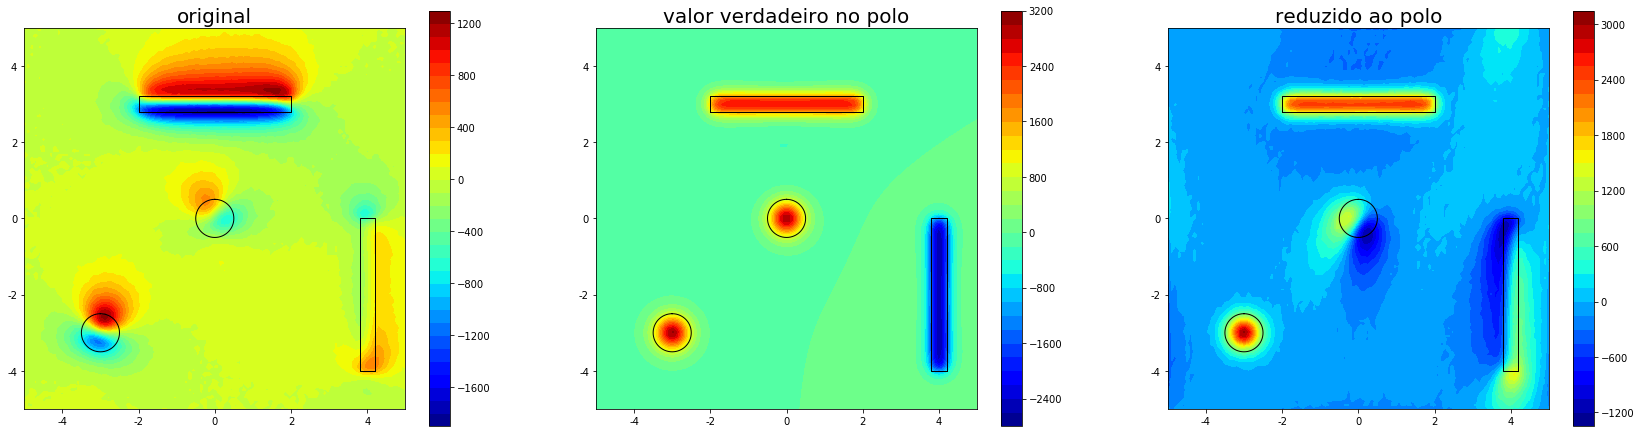

In [27]:
# Plot
mpl.figure(figsize=(25, 10))
mpl.subplots_adjust(top=0.95, left=0.05, right=0.95)
mpl.subplot(1, 3, 1)
mpl.title("original", fontsize=20)
mpl.axis('scaled')
levels = mpl.contourf(yp, xp, tf, shape, 30)
mpl.colorbar(shrink=0.7)
for i in range(pol.__len__()):
    mpl.polygon(pol[i], '-k', xy2ne=True)
#mpl.contour(yp, xp, gxz, shape, 12, color='k')
mpl.m2km()
mpl.subplot(1, 3, 2)
mpl.title("valor verdadeiro no polo", fontsize=20)
mpl.axis('scaled')
levels = mpl.contourf(yp, xp, truetf, shape, 30)
mpl.colorbar(shrink=0.7)
for i in range(pol.__len__()):
    mpl.polygon(pol[i], '-k', xy2ne=True)
#mpl.contour(yp, xp, gyz, shape, 12, color='k')
mpl.m2km()
mpl.subplot(1, 3, 3)
mpl.title("reduzido ao polo", fontsize=20)
mpl.axis('scaled')
levels = mpl.contourf(yp, xp, pole, shape, 30)
mpl.colorbar(shrink=0.7)
for i in range(pol.__len__()):
    mpl.polygon(pol[i], '-k', xy2ne=True)
#mpl.contour(yp, xp, gyz, shape, 12, color='k')
mpl.m2km()

As células abaixo calculam a __amplitude do gradiente total__ (também chamado de __sinal analítico__) do campo e então plotam

In [28]:
total_grad_amp = transform.tga(xp, yp, tf, shape)

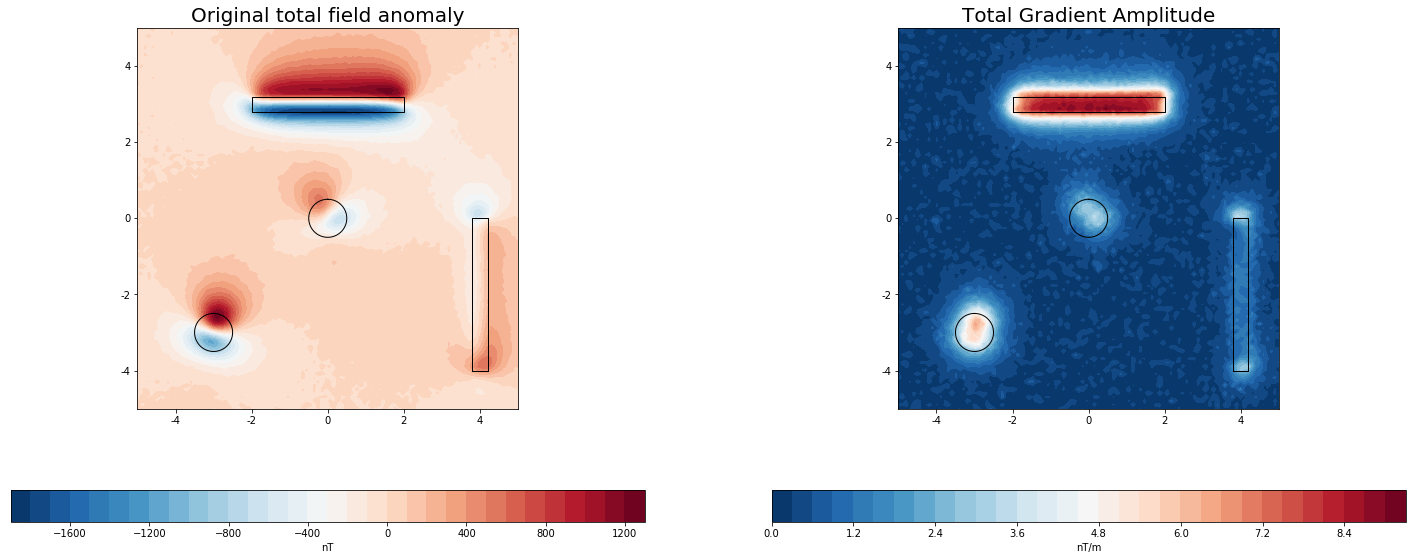

In [29]:
#Plot
mpl.figure(figsize=(25, 10))
mpl.subplot(1, 2, 1)
mpl.title("Original total field anomaly", fontsize=20)
mpl.axis('scaled')
mpl.contourf(yp, xp, tf, shape, 30, cmap=mpl.cm.RdBu_r)
mpl.colorbar(orientation='horizontal').set_label('nT')
for i in range(pol.__len__()):
    mpl.polygon(pol[i], '-k', xy2ne=True)
mpl.m2km()
mpl.subplot(1, 2, 2)
mpl.title("Total Gradient Amplitude", fontsize=20)
mpl.axis('scaled')
mpl.contourf(yp, xp, total_grad_amp, shape, 30, cmap=mpl.cm.RdBu_r)
mpl.colorbar(orientation='horizontal').set_label('nT/m')
for i in range(pol.__len__()):
    mpl.polygon(pol[i], '-k', xy2ne=True)
mpl.m2km()
mpl.show()